In [1]:
import donkeycar as dk
import keras
import h5py
import os
import sys
import time
import numpy as np
import pandas as pd
from donkeycar import utils
from PIL import Image
from donkeycar.tools.fisheye_undistort import undistort
from donkeycar.parts.stores.augmentation import augment
from random import shuffle

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [16, 8]

Using TensorFlow backend.


In [2]:
data_dir = '../../donkeycar/d2/data.ws'
model_path = '../../donkeycar/d2/models/ws.4fc_l1.colorspace'
use_regression = True
# data_dir = sys.argv[1]
# model_path = sys.argv[2]
# use_regression = sys.argv[3] == 'r'

In [3]:
def dataset_from_tub(tub_path, limit=500):
    tub = dk.parts.Tub(tub_path)
    idx = tub.get_index(shuffled=False)
    result = []
    if limit==-1:
        limit = len(idx)

    for i in range(limit):
        rec = tub.get_record(idx[i])
        result.append((rec['cam/image_array'], rec['user/angle'], rec['user/throttle']))
    return result

def dataset_from_all_tubs(data_path):
    tub_paths = [os.path.join(data_path, n) for n in os.listdir(data_path)]
    result = []
    for p in tub_paths:
        result = result + dataset_from_tub(p, limit=-1)
    return result

# BINS = array([-0.9765672 , -0.22111631, -0.16817142, -0.13134938, -0.10334459,
#        -0.07650948, -0.04920462, -0.02300015,  0.00720189,  0.03442041,
#         0.06426511,  0.09369569,  0.12904788,  0.16444255,  0.2016602 ,
#         0.23998156,  0.28286744,  0.34177643,  0.48355854,  1.        ])

BINS = [-1.0, -0.7962963 , -0.55, -0.31859399, -0.28888889, -0.27279798, -0.2503496 ,
       -0.22473535, -0.2       , -0.16676868, -0.11454837, -0.0353191 ,
        0.01857333,  0.07800226,  0.12310686,  0.15539933,  0.17979046,
        0.19944761,  0.21551724,  0.23020181,  0.26149425,  0.52298851, 0.76, 1.0]

def bin_it(i):
    r = np.zeros(23)
    r[i-1] = 1
    return r

def bin_angle_out(angle_out):
    digits = np.digitize(angle_out, bins=BINS)
    return np.asarray([bin_it(i) for i in digits], dtype="float64")

def augment_batch(batch_data):
    for i in range(len(batch_data)):
        batch_data[i] = augment(batch_data[i])

def batch_gen(dataset, batch_size=128, augmented=False, bin_angle=True):
    while True:
        for i in range(batch_size, len(dataset), batch_size):
            batch = []
            for j in range(-batch_size, 0):
                data = dataset[i+j]
                data = {'cam/image_array': data[0],
                   'user/angle': data[1],
                   'user/throttle': data[2]}
                if augmented:
                    dasta = augment(data)
            
                batch.append(data)
            X = np.array([d['cam/image_array'] for d in batch])
            Y = [np.array([d['user/angle'] for d in batch]), np.array([d['user/throttle'] for d in batch])]
            if bin_angle:
                Y[0] = bin_angle_out(Y[0])
            yield X, Y

Tub does exist
Tub does exist
Tub does exist
Tub does exist
Tub does exist
Tub does exist
Tub does exist
Tub does exist


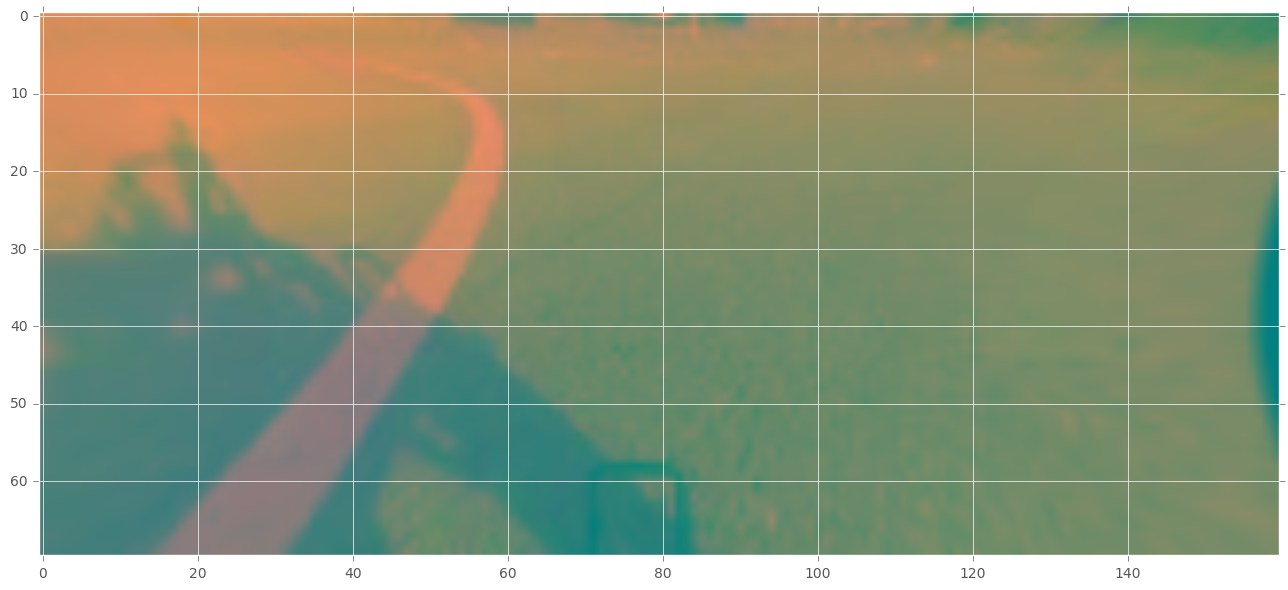

In [4]:
dataset = dataset_from_all_tubs(data_dir)
plt.imshow(dataset[100][0])

In [5]:
BATCH_SIZE=128
SPLIT = 0.8

In [6]:
shuffle(dataset)
split = int(SPLIT * len(dataset))
train_set = dataset[0:split]
val_set = dataset[split:]
if use_regression:
    train_gen = batch_gen(train_set, augmented=True, batch_size=BATCH_SIZE, bin_angle=False)
    val_gen = batch_gen(val_set, augmented=False, batch_size=BATCH_SIZE, bin_angle=False)
else:
    train_gen = batch_gen(train_set, augmented=True, batch_size=BATCH_SIZE, bin_angle=True)
    val_gen = batch_gen(val_set, augmented=False, batch_size=BATCH_SIZE, bin_angle=True)


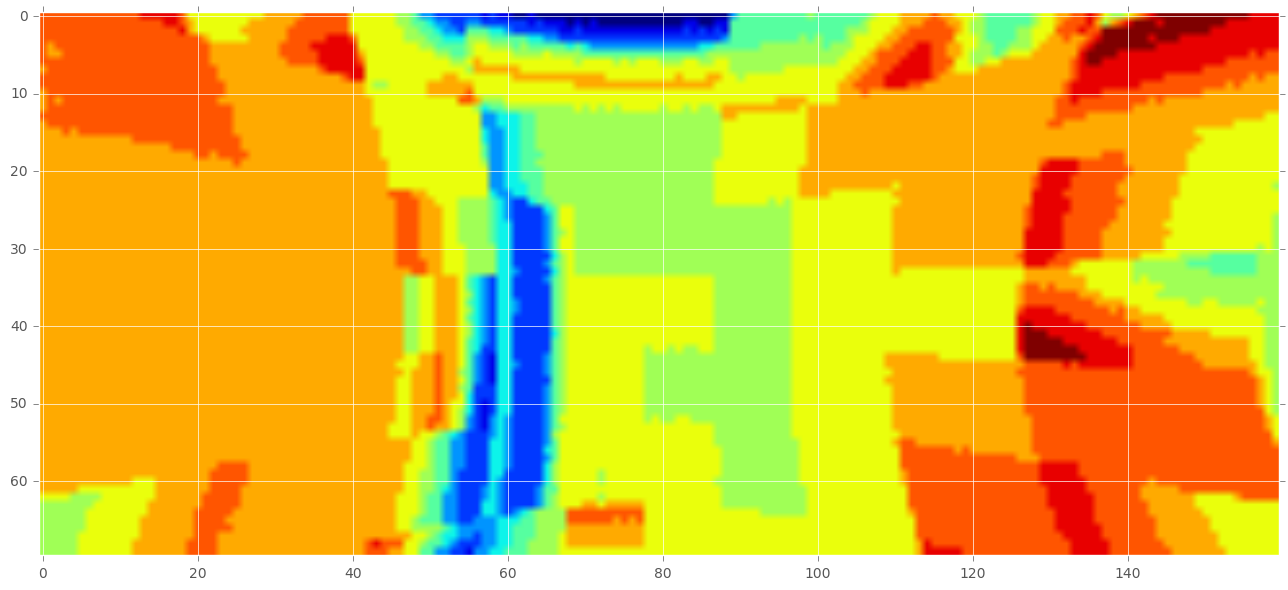

In [19]:
plt.imshow(train_set[100][0][:,:,1])

In [7]:
def classification_model():
    from keras.layers import Input, Dense, merge
    from keras.models import Model
    from keras.layers import Convolution2D, MaxPooling2D, Reshape, BatchNormalization
    from keras.layers import Activation, Dropout, Flatten, Dense

    img_in = Input(shape=(70, 160, 3), name='img_in')                      # First layer, input layer, Shape comes from camera.py resolution, RGB
    x = img_in
    x = Convolution2D(24, (5,5), strides=(2,2), activation='relu')(x)       # 24 features, 5 pixel x 5 pixel kernel (convolution, feauture) window, 2wx2h stride, relu activation
    x = Convolution2D(32, (5,5), strides=(2,2), activation='relu')(x)       # 32 features, 5px5p kernel window, 2wx2h stride, relu activatiion
    x = Convolution2D(64, (5,5), strides=(2,2), activation='relu')(x)       # 64 features, 5px5p kernal window, 2wx2h stride, relu
    x = Convolution2D(64, (3,3), strides=(1,1), activation='relu')(x)       # 64 features, 3px3p kernal window, 2wx2h stride, relu
#     x = Convolution2D(64, (3,3), strides=(1,1), activation='relu')(x)       # 64 features, 3px3p kernal window, 1wx1h stride, relu

    # Possibly add MaxPooling (will make it less sensitive to position in image).  Camera angle fixed, so may not to be needed

    x = Flatten(name='flattened')(x)                                        # Flatten to 1D (Fully connected)
#     x = Dense(200, activation='relu')(x)                                    # Classify the data into 100 features, make all negatives 0
#     x = Dropout(.1)(x)                                                      # Randomly drop out (turn off) 10% of the neurons (Prevent overfitting)
    x = Dense(100, activation='relu')(x)                                     # Classify the data into 50 features, make all negatives 0
    x = Dropout(.1)(x)
    x = Dense(50, activation='relu')(x)                                     # Classify the data into 50 features, make all negatives 0
    x = Dropout(.1)(x)  
    x = Dense(10, activation='relu')(x)                                     # Classify the data into 50 features, make all negatives 0
    x = Dropout(.1)(x)  

    # Randomly drop out 10% of the neurons (Prevent overfitting)
    #categorical output of the angle
    angle_out = Dense(25, activation='softmax', name='angle_out')(x)        # Connect every input with every output and output 15 hidden units. Use Softmax to give percentage. 15 categories and find best one based off percentage 0.0-1.0

    #continous output of throttle
    throttle_out = Dense(1, activation='relu', name='throttle_out')(x)      # Reduce to 1 number, Positive number only

    model = Model(inputs=[img_in], outputs=[angle_out, throttle_out])
    model.compile(optimizer=keras.optimizers.RMSprop(lr=0.0002),
                  loss={'angle_out': 'categorical_crossentropy',
                        'throttle_out': 'mean_squared_error'},
                  loss_weights={'angle_out': 0.9, 'throttle_out': .001})

    return model


In [8]:
def regression_model():
    from keras.layers import Input, Dense, merge
    from keras.models import Model
    from keras.layers import Convolution2D, MaxPooling2D, Reshape, BatchNormalization
    from keras.layers import Activation, Dropout, Flatten, Dense

    img_in = Input(shape=(70,160,3), name='img_in')
    x = img_in
    x = Convolution2D(24, (5,5), strides=(2,2), activation='relu')(x)
    x = Convolution2D(32, (5,5), strides=(2,2), activation='relu')(x)
    x = Convolution2D(64, (5,5), strides=(2,2), activation='relu')(x)
    x = Convolution2D(64, (3,3), strides=(2,2), activation='relu')(x)
#     x = Convolution2D(64, (3,3), strides=(1,1), activation='relu')(x)

    x = Flatten(name='flattened')(x)
    x = Dense(250, activation='linear')(x)
    x = Dropout(.1)(x)
    x = Dense(50, activation='linear')(x)
    x = Dropout(.1)(x)
    x = Dense(10, activation='linear')(x)
    x = Dropout(.1)(x)
    #categorical output of the angle
    angle_out = Dense(1, activation='linear', name='angle_out')(x)

    #continous output of throttle
    throttle_out = Dense(1, activation='linear', name='throttle_out')(x)

    model = Model(inputs=[img_in], outputs=[angle_out, throttle_out])

    model.compile(optimizer=keras.optimizers.RMSprop(lr=0.00008),
                  loss={'angle_out': 'mean_squared_error',
                        'throttle_out': 'mean_squared_error'},
                  loss_weights={'angle_out': 1.0, 'throttle_out': .00})
    return model

In [9]:
if use_regression:
    model = regression_model()
else:    
    model = classification_model()

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
img_in (InputLayer)              (None, 70, 160, 3)    0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 33, 78, 24)    1824        img_in[0][0]                     
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 15, 37, 32)    19232       conv2d_1[0][0]                   
____________________________________________________________________________________________________
conv2d_3 (Conv2D)                (None, 6, 17, 64)     51264       conv2d_2[0][0]                   
___________________________________________________________________________________________

In [ ]:
save_best = keras.callbacks.ModelCheckpoint(model_path,
                                            monitor='val_loss',
                                            verbose=1,
                                            save_best_only=True,
                                            mode='min')

#stop training if the validation error stops improving.
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',
                                           min_delta=.000005,
                                           patience=10,
                                           verbose=1,
                                           mode='auto')
callbacks_list = [save_best, early_stop]

model.fit_generator(train_gen,
                        steps_per_epoch=len(train_set)/BATCH_SIZE,
                        epochs=100,
                        verbose=1,
                        validation_data=val_gen,
                        callbacks=callbacks_list,
                        validation_steps=(len(val_set)/BATCH_SIZE + 1))

Epoch 1/100
532/531 [==============================] - 28s - loss: 14.5697 - angle_out_loss: 14.5697 - throttle_out_loss: 7.6801 - val_loss: 0.0389 - val_angle_out_loss: 0.0389 - val_throttle_out_loss: 0.1150
Epoch 2/100
532/531 [==============================] - 27s - loss: 0.0314 - angle_out_loss: 0.0314 - throttle_out_loss: 0.1055 - val_loss: 0.0197 - val_angle_out_loss: 0.0197 - val_throttle_out_loss: 0.1044
Epoch 3/100
532/531 [==============================] - 27s - loss: 0.0195 - angle_out_loss: 0.0195 - throttle_out_loss: 0.1074 - val_loss: 0.0141 - val_angle_out_loss: 0.0141 - val_throttle_out_loss: 0.1143
Epoch 4/100
532/531 [==============================] - 27s - loss: 0.0150 - angle_out_loss: 0.0150 - throttle_out_loss: 0.1091 - val_loss: 0.0121 - val_angle_out_loss: 0.0121 - val_throttle_out_loss: 0.1130
Epoch 5/100
532/531 [==============================] - 27s - loss: 0.0130 - angle_out_loss: 0.0130 - throttle_out_loss: 0.1130 - val_loss: 0.0128 - val_angle_out_loss: 0.

In [18]:
bin_angle_out([0.9])
np.argmax([0,0,1,0,0])

2